In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Main Model: Voting Classifier

In [2]:
aapl_with_features = pd.read_csv('../data/all_data/all_AAPL_data.csv')
googl_with_features = pd.read_csv('../data/all_data/all_GOOGL_data.csv')
msft_with_features = pd.read_csv('../data/all_data/all_MSFT_data.csv')

In [3]:
tickers = ['AAPL', 'GOOGL', 'MSFT']
data_dict = {
    'AAPL': aapl_with_features,
    'GOOGL': googl_with_features,
    'MSFT': msft_with_features
}
color_dict = {
     'AAPL': 'grey',
    'GOOGL': 'yellow',
    'MSFT': 'green'
}

In [4]:
def get_target(input_df, ticker):
    df = input_df.copy()
    df['Target'] = (df[f'Close_{ticker}'].shift(-1) > df[f'Close_{ticker}']).astype(int)
    df.dropna(inplace=True)
    return df

In [5]:
result_dict = {}
for i, share in enumerate(tickers):
    df = get_target(data_dict[share], share)
    features = [col for col in df.columns if col not in ['Target', 'index', 'DATE']]

    X = df[features]
    y = df['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    rfe = RFE(estimator=XGBClassifier(n_estimators=50, max_depth=3,learning_rate=0.1,eval_metric='logloss', random_state=42, n_jobs=-1), n_features_to_select=10)
    rfe.fit(X_train, y_train)
    
    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)
    selected_cols = X.columns[rfe.support_]

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_leaf=10, random_state=42, n_jobs=-1))
    ])
    
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)),
    ])
    
    xgb_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBClassifier(n_estimators=50, max_depth=3,learning_rate=0.1,eval_metric='logloss', random_state=42, n_jobs=-1)),
    ])

    main_model = VotingClassifier(estimators=[('xgb', xgb_pipeline),('svc', svm_pipeline),('rf', rf_pipeline),],
                                  voting='soft')
    
    main_model.fit(X_train_selected, y_train)

    y_pred = main_model.predict(X_test_selected)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print('*' * 40)
    print(f"Results for {share}:")
    print("Accuracy:", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("ROC AUC score:", roc_auc)
    result_dict[share] = [acc, precision, recall, roc_auc]
    
    
    

****************************************
Results for AAPL:
Accuracy: 0.5257936507936508
Precision: 0.527542372881356
Recall: 0.939622641509434
ROC AUC score: 0.5032841241019973
****************************************
Results for GOOGL:
Accuracy: 0.5119047619047619
Precision: 0.5318840579710145
Recall: 0.6847014925373134
ROC AUC score: 0.5001897293195041
****************************************
Results for MSFT:
Accuracy: 0.5158730158730159
Precision: 0.5236318407960199
Recall: 0.8003802281368821
ROC AUC score: 0.5028872095041257


In [6]:
df_to_save = pd.DataFrame.from_dict(
    result_dict, 
    orient='index',
    columns=['Accuracy', 'Precision', 'Recall', 'ROC AUC']
)
print(df_to_save)
df_to_save.to_csv('../models_results/main_model_results.csv')

       Accuracy  Precision    Recall   ROC AUC
AAPL   0.525794   0.527542  0.939623  0.503284
GOOGL  0.511905   0.531884  0.684701  0.500190
MSFT   0.515873   0.523632  0.800380  0.502887


In [7]:
rf_results = pd.read_csv('../models_results/RF_results.csv')
svm_results = pd.read_csv('../models_results/SVM_results.csv')
xgb_results = pd.read_csv('../models_results/XGB_results.csv')
lr_results = pd.read_csv('../models_results/LR_results.csv')
bs1_results = pd.read_csv('../models_results/bs1_results.csv')
bs2_results = pd.read_csv('../models_results/bs2_results.csv')
bs3_results = pd.read_csv('../models_results/bs3_results.csv')
main_model = pd.read_csv('../models_results/main_model_results.csv')

bs1_results['Model'] = 'Based on yesterday'
bs2_results['Model'] = 'Always rise'
bs3_results['Model'] = 'Based on SMA'
rf_results['Model'] = 'Random Forest'
svm_results['Model'] = 'SVM'
xgb_results['Model'] = 'XGBoost'
lr_results['Model'] = 'Logistic Regression'
main_model['Model'] = 'Ensemble (Main)'

all_dfs = [bs1_results, bs2_results, bs3_results, rf_results, svm_results, xgb_results, lr_results, main_model]

combined_df = pd.concat(all_dfs)

if 'Unnamed: 0' in combined_df.columns:
    combined_df = combined_df.rename(columns={'Unnamed: 0': 'Ticker'})

combined_df = combined_df.sort_values(by=['Ticker', 'Accuracy'], ascending=[True, False])

combined_df = combined_df.reset_index(drop=True)

print(combined_df)




   Ticker  Accuracy  Precision    Recall   ROC AUC                Model
0    AAPL  0.532738   0.530955  0.954717  0.509785                  SVM
1    AAPL  0.527204   0.527204  1.000000  0.500000          Always rise
2    AAPL  0.526786   0.522766  0.502380  0.502380        Random Forest
3    AAPL  0.525794   0.527542  0.939623  0.503284      Ensemble (Main)
4    AAPL  0.523022   0.541005  0.630763  0.516774         Based on SMA
5    AAPL  0.511905   0.511297  0.511321  0.511321              XGBoost
6    AAPL  0.511905   0.531707  0.615819  0.504530  Logistic Regression
7    AAPL  0.499305   0.525047  0.525245  0.497818   Based on yesterday
8   GOOGL  0.523431   0.523431  1.000000  0.500000          Always rise
9   GOOGL  0.512897   0.496313  0.497201  0.497201              XGBoost
10  GOOGL  0.511905   0.531884  0.684701  0.500190      Ensemble (Main)
11  GOOGL  0.510913   0.523497  0.893657  0.484964                  SVM
12  GOOGL  0.501495   0.520700  0.589558  0.497244         Based

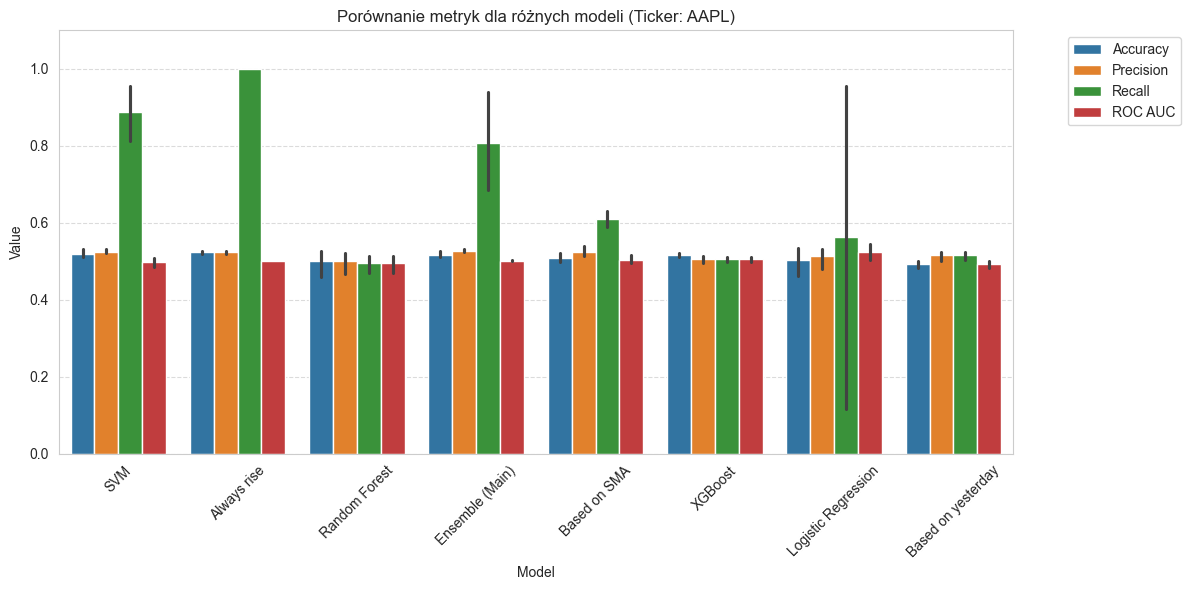